# Causal explanation and COMPAS recidivism algorithm

## Outline and motivations

In this notebook, we apply `SearchForExplanation` to investigate the impact of race on the recidivism predictions made by the Correctional Offender Management Profiling for Alternative Sanctions  ([COMPAS](https://en.wikipedia.org/wiki/COMPAS_(software))) algorithm. Our point of departure will be a dataset [released by Propublica](https://github.com/propublica/compas-analysis/). We start with training a neural network surrogate emulating the algorithm, which we then query using `SearchForExplanation`, illustrating how increasing the query complexity and composing a neural network with an external Bayesian causal model capturing some of the real-world dependencies results in a more nuanced evaluation of the presence and location of bias.



In [1]:
# TODO expand and clean up once notebook is done, add TOC

## Setup

Our main tools will be ChiRho and PyTorch. Let's start by loading the necessary dependencies and defining a few helper functions.

In [5]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchsummary import summary
from typing import Optional, Union
import pyro.distributions.constraints as constraints
import pyro.distributions as dist

import os

from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition
from chirho.interventional.handlers import do


import pyro


from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports

from mpl_toolkits.axes_grid1 import make_axes_locatable


from torch.distributions.utils import broadcast_all


smoke_test = "CI" in os.environ


num_samples = 5000 if not smoke_test else 30
num_steps = 300 if not smoke_test else 10
epochs = 1500 if not smoke_test else 10


device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# a data preprocessing  function
def make_dummies_with_limits(
        df_:pd.DataFrame,
        colname:str,
        min_recs:Optional[Union[int, float]] = 0.005,
        max_dummies:Optional[int] = 20,
        defcatname:Optional[str] = 'Other',
        nospacechr:Optional[str] = '_'
    ) -> pd.DataFrame:
    df = df_.copy()
    # min_recs is the number of repeated recalls
    if min_recs < 1:
        min_recs = df.shape[0]*min_recs
    topvals_df = df.groupby(colname).size().reset_index(name="counts").\
                    sort_values(by="counts", ascending=False).reset_index()
    other_l = topvals_df[(topvals_df.index > max_dummies) |\
                         (topvals_df.counts < min_recs)][colname].to_list()
    # Set the column name to the other_l if the column is in other_l
    if len(other_l):
        df.loc[df[colname].isin(other_l), colname] = defcatname
    # Remove nospacechr characters from the column name.
    if len(nospacechr) > 0:
        df[colname] = df[colname].str.replace(' ',\
                                                  nospacechr, regex=False)
    return pd.get_dummies(df, prefix=[colname], columns=[colname])

In [7]:
# extracting samples from a multi-world trace, using them to build a frame

def extract_samples(trace, mwc, antecedents_names = ["age", "priors_count", "race_African-American"],
varnames =  ["age", "priors_count", "race_African-American", "prob", "score"]):

    trace.trace.compute_log_prob()

    dic = {}

    tensors = {varname: trace.trace.nodes[varname]["value"] for varname in varnames}

    with mwc:
        for varname in varnames:
            dic[f"{varname[:4]}_base"] = gather(
                                    tensors[varname],
                                    IndexSet(**{ant: {0} for ant in antecedents_names}),
                                )

            dic[f"{varname[:4]}_nec"] = gather(
                                    tensors[varname],
                                    IndexSet(**{ant: {1} for ant in antecedents_names}),
            )

            dic[f"{varname[:4]}_suf"] = gather(
                                    tensors[varname],
                                    IndexSet(**{ant: {2} for ant in antecedents_names}),
            )


            if f'__cause____antecedent_{varname}' in trace.trace.nodes.keys(): 
                dic[f"{varname[:4]}_i"] = trace.trace.nodes[f'__cause____antecedent_{varname}']["value"]

            if f'__cause____witness_{varname}' in trace.trace.nodes.keys():
                dic[f"{varname[:4]}_w"] = trace.trace.nodes[f'__cause____witness_{varname}']["value"]

            if f"__cause____consequent_{varname}" in trace.trace.nodes.keys():
               
                dic[f"{varname[:4]}_c_nec"] = gather(
                                    trace.trace.nodes[f"__cause____consequent_{varname}"]["log_prob"],
                                    IndexSet(**{ant: {1} for ant in antecedents_names}),
                    )

                dic[f"{varname[:4]}_c_suf"] = gather(
                                    trace.trace.nodes[f"__cause____consequent_{varname}"]["log_prob"],
                                    IndexSet(**{ant: {2} for ant in antecedents_names}),
                    )


        dic = {key: value.detach().flatten().numpy() for key, value in zip(dic.keys(), broadcast_all(*dic.values()))}

        frame = pd.DataFrame(dic)

        return frame

In [8]:
# NN training loop for the surrogate model

def train(train_tensors, test_tensors):

    for t in range(len(train_tensors)):

        X_train_temp = train_tensors[t]
        X_test_temp = test_tensors[t]

       
        model = RecidivismNN(X_train_temp).to(device)
        loss_fn = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

        for epoch in range(epochs):

            model.train()

            y_logits = model(X_train_temp).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits, y_train_tensor)
            acc = accuracy_fn(y_true=y_train_tensor, 
                            y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            model.eval()

            with torch.inference_mode():

                test_logits = model(X_test_temp).squeeze()
                test_probs = torch.sigmoid(test_logits)
                test_pred = torch.round(torch.sigmoid(test_logits))
                test_loss = loss_fn(test_logits, y_test_tensor)
                test_acc = accuracy_fn(y_true=y_test_tensor,
                                        y_pred=test_pred)
                test_auc_score = roc_auc_score(y_test, test_probs.detach().numpy())     

            if epoch % 100 == 0:
                print(f"""Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, 
                Test Accuracy: {test_acc:.2f}, Test AUC: {test_auc_score}%""")

    return model

In [9]:
# visualize variables across possible worlds

def plot_world_histograms(frame, core: str, title= ""):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax = ax.flatten()

    ax[0].hist(frame[f'{core}_base'], bins=20, color='blue', alpha=0.7)
    ax[0].set_title("baseline world")

    ax[1].hist(frame[f'{core}_nec'], bins=20, color='blue', alpha=0.7)
    ax[1].set_title("necessity world")

    ax[2].hist(frame[f'{core}_suf'], bins=20, color='blue', alpha=0.7)
    ax[2].set_title("sufficiency world")

    plt.tight_layout()


    plt.suptitle(f"{core.capitalize()}{ title} across worlds", y = 1.05)
    sns.despine()
    plt.show()

In [10]:
# visualize the effect of an intervention on the outcome

def plot_conditioned_on_intervention(frame, core = str, ):

    intervened_frame = frame[frame[f'{core}_i']== 0]

    joint_inter_score = intervened_frame[f'scor_c_nec'] + intervened_frame[f'scor_c_suf']

    freq = (np.exp(joint_inter_score) > .5).mean()

    fig, ax = plt.subplots(figsize=(5.5, 5.5))

    ax.set_title(f"Pr(outcome differs|{core} differs) = {freq:.2f}")

    plt.scatter(intervened_frame[f'{core}_nec'], np.exp(joint_inter_score), color='blue', alpha=0.5, s = 50,
    marker = "x", label= "outcome_differs")
    plt.scatter(intervened_frame[f'{core}_nec'], intervened_frame[f'prob_nec'], label = "prob in nec", alpha = .6, s= 8)
    plt.legend()

    divider = make_axes_locatable(ax)
    #ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", .7, pad=0.2, sharey=ax)

    ax_histy.axis("off")
    
    bins = 40
    ax_histy.hist(intervened_frame[f'prob_nec'], bins=bins, orientation='horizontal')
    
    ax.set_ylabel("probability in necessity world")
    ax.set_xlabel(core)
    sns.despine()
    plt.show()

In [11]:
# accuracy for the surrogate model
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

## Data

In [12]:
# TODO discuss the inclusion of the NN selection experiments: is it worth the complication

We will use a [cleaned dataset released by ProPublica](https://github.com/propublica/compas-analysis/blob/master/cox-violent-parsed.csv). The units of analysis are humans subjected to the COMPAS evaluation. While we do not have access to the algorithm itself, we do have access to its outputs and the ground truth of whether the subjects actually recidivated. 

So, we will build a neural network surrogate—a model that *predicts its predictions* based on the available information—and query it afterward. A range of experiments (kept aside for the sake of brevity) have shown that, without much loss of accuracy, most of the information can be discarded. It is enough to focus on `age`, `priors_count`, and `race_African_American`, so this is what we will do in this notebook.


In [13]:
# get data, drop unused variables, train-test split
df = pd.read_csv('datasets/cox-violent-parsed_filt.csv')

df = df[
    (df.is_recid != -1) &
    (df.decile_score != -1) &
    (df.days_b_screening_arrest <= 30) &
    (df.days_b_screening_arrest >= -30) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df = pd.get_dummies(df, columns=['sex', 'race'])

df = make_dummies_with_limits(df, 'c_charge_degree')

df['compas_score'] = np.where(df['score_text'] == 'Low', 0, 1)

df.drop(['id', 'name', 'first', 'last', 'dob', 'r_charge_degree', 'c_days_from_compas',
         'r_days_from_arrest', 'r_offense_date', 'r_charge_desc',  
         'event', 'r_jail_in', 'violent_recid', 'is_violent_recid', 'vr_charge_degree', 'vr_offense_date',
           'vr_charge_desc',
            'type_of_assessment', 
            'v_type_of_assessment', 'decile_score.1', 'v_decile_score',
            'v_score_text', 'priors_count.1', 'screening_date',
               'c_charge_desc', 'c_jail_in', 'c_jail_out', 'score_text', 'decile_score', 'days_b_screening_arrest',
         'age_cat', 'c_charge_desc', 'c_jail_in', 'c_jail_out', 'score_text',
           'decile_score', 'days_b_screening_arrest',], 
        axis=1, inplace=True)

recidivism = df.iloc[:,[0, 4, 5, 8,  22]]
recidivism.head()
print(recidivism.info())

rand = 9
np.random.seed(rand)

y = recidivism['compas_score']
X = recidivism.drop(['compas_score', 'is_recid'], axis=1).copy().astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)


X_train_tensor = torch.tensor(X_train.values.astype(float))
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values.astype(float))
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

print("Train data shape", X_train_tensor.shape)
print("Test data shape", X_test_tensor.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 14788 entries, 0 to 18315
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    14788 non-null  int64
 1   priors_count           14788 non-null  int64
 2   is_recid               14788 non-null  int64
 3   race_African-American  14788 non-null  bool 
 4   compas_score           14788 non-null  int64
dtypes: bool(1), int64(4)
memory usage: 592.1 KB
None
Train data shape torch.Size([11830, 3])
Test data shape torch.Size([2958, 3])


There are at least *prima facie* reasons to investigate the accuracy and the presence of bias in the algorithm's recommendations, suggested by the following considerations. 

Overall, its recommendations seem better than guessing (although far from perfect). However, when we group entries by `race_African_American`, there appear to be significant differences. One is that the rate of false positives is higher (23.7% vs. 15.4%), which suggests unfair treatment. Another is that African-American citizens recidivate with higher frequency, and the algorithm has a higher true positive rate for them than for other subjects. This suggests that it is by no means clear what formal definitions of fairness are desirable in this context, or whether they are satisfied.

This sparked an extended public debate, beginning with [the ProPublica stance](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) and a [polemical response in The Washington Post](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/). Rather than engaging directly with these debates, we propose to employ surrogate modeling and causal reasoning to systematically disambiguate and address at least some of the issues at play.


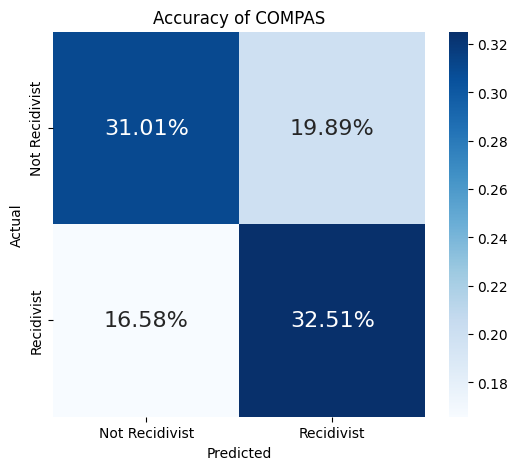

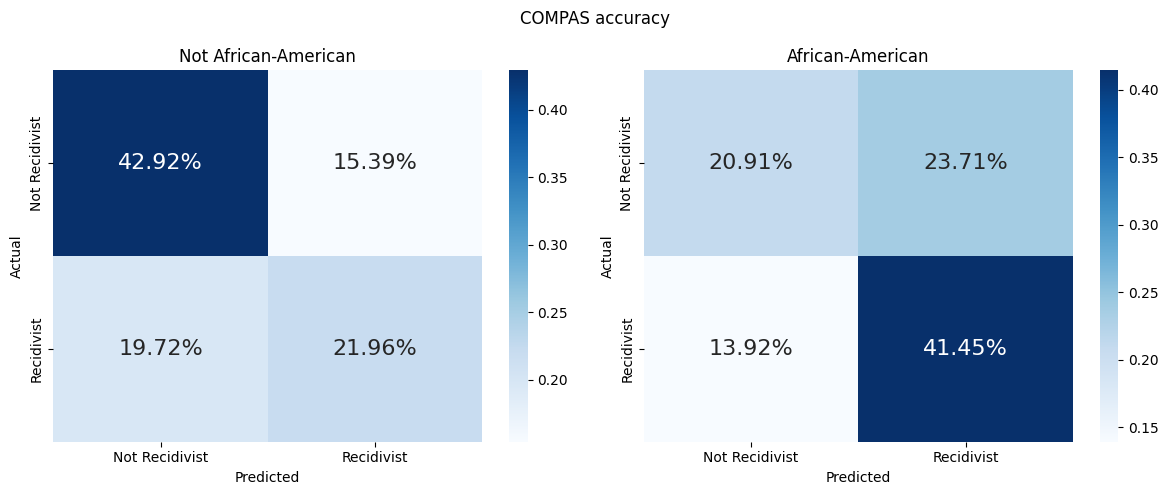

In [14]:
# inspect accuracies 

cf_matrix = metrics.confusion_matrix(recidivism.is_recid, recidivism.compas_score)
class_labels = ['Not Recidivist', 'Recidivist']
plt.figure(figsize=(6, 5))

sns.heatmap(cf_matrix/np.sum(cf_matrix),
             annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16},
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Accuracy of COMPAS')
plt.show()

recidivism_naa = recidivism[recidivism['race_African-American'] == 0]
recidivism_aa = recidivism[recidivism['race_African-American'] == 1]

cf_matrix_naa = metrics.confusion_matrix(recidivism_naa.is_recid, recidivism_naa.compas_score)
cf_matrix_aa = metrics.confusion_matrix(recidivism_aa.is_recid, recidivism_aa.compas_score)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cf_matrix_naa / np.sum(cf_matrix_naa), annot=True, fmt='.2%', cmap='Blues', annot_kws={'size': 16},
            xticklabels=class_labels, yticklabels=class_labels, ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Not African-American')

sns.heatmap(cf_matrix_aa / np.sum(cf_matrix_aa), annot=True, fmt='.2%', cmap='Blues', annot_kws={'size': 16},
            xticklabels=class_labels, yticklabels=class_labels, ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_title('African-American')

plt.suptitle("COMPAS accuracy")

plt.tight_layout()
plt.show()

Before moving forward, let us also take a quick look at the empirical distributions of predictors we will be using - they will later on turn out to be quite relevant to determining what queries are being answered.

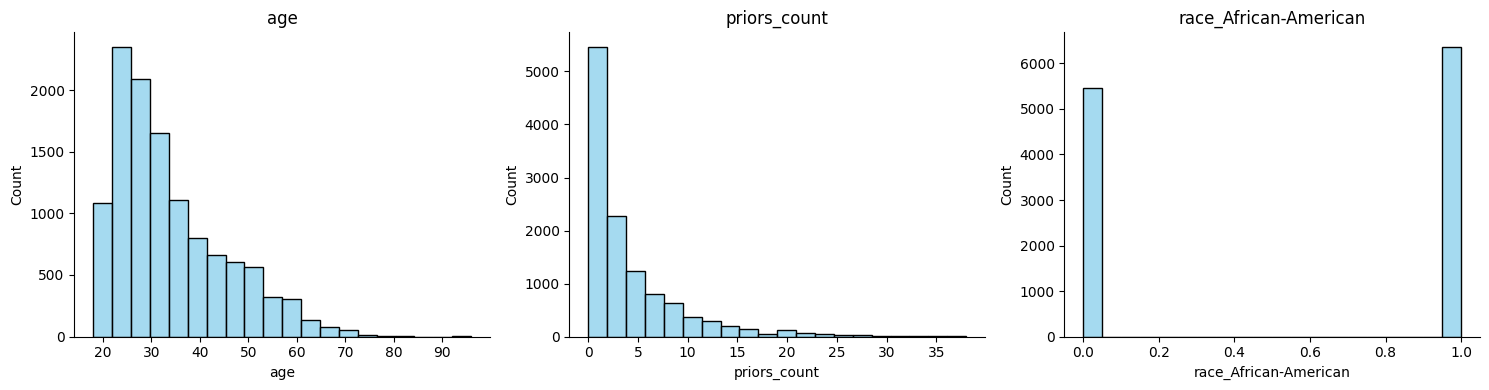

In [15]:
# inspect predictor distributions

n_cols = 3
n_features = len(X_train.columns)

n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() 

for i, col in enumerate(X_train.columns):
    sns.histplot(X_train[col].astype(float), bins=20, ax=axes[i], kde=False, color="skyblue")
    axes[i].set_title(col)
    sns.despine(ax=axes[i]) 

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Neural network training and evaluation

Now we build a relatively simple neural surrogate predicting the algorithm's decisions (*not the outcomes themselves*, as we now strive to understand the algorithm). Leading to the use of this architecture is a range of experiments, employing both more variables and richer architectures, without much improvement in performance. It seems that with this dataset size and a domain this noisy, it is hard to do much better with the information at hand.

In [16]:
class RecidivismNN(nn.Module):
    def __init__(self, X):
        super().__init__()
        self.input = X.shape[-1]
        print("Input shape: ", self.input)
      
        self.stack = nn.Sequential(
            nn.Linear(self.input, 32),  #plain linear: test accuracy: 64%, AUC: .8
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.float()
        return  self.stack(x)
       
model_0 = RecidivismNN(X_train_tensor).to(device)
summary(model_0, input_size=(X_train_tensor.shape[1],), device=device)

Input shape:  3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             128
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [17]:
torch.manual_seed(rand)
train_tensors = [X_train_tensor]
test_tensors = [X_test_tensor]
nn_model = train(train_tensors, test_tensors)

Input shape:  3
Epoch: 0 | Loss: 1.36865, Accuracy: 47.86% | Test Loss: 5.22315, 
                Test Accuracy: 53.48, Test AUC: 0.3865638230235498%
Epoch: 100 | Loss: 0.60141, Accuracy: 67.99% | Test Loss: 0.62326, 
                Test Accuracy: 62.91, Test AUC: 0.8230687990621233%
Epoch: 200 | Loss: 0.53582, Accuracy: 72.79% | Test Loss: 0.55777, 
                Test Accuracy: 68.76, Test AUC: 0.8184359197218709%
Epoch: 300 | Loss: 0.53119, Accuracy: 73.79% | Test Loss: 0.53960, 
                Test Accuracy: 71.74, Test AUC: 0.8192648766648046%
Epoch: 400 | Loss: 0.52870, Accuracy: 73.31% | Test Loss: 0.53933, 
                Test Accuracy: 71.67, Test AUC: 0.8216258765031018%
Epoch: 500 | Loss: 0.52531, Accuracy: 73.27% | Test Loss: 0.53374, 
                Test Accuracy: 72.79, Test AUC: 0.8226385867168435%
Epoch: 600 | Loss: 0.52394, Accuracy: 73.35% | Test Loss: 0.53020, 
                Test Accuracy: 73.26, Test AUC: 0.8233524681739335%
Epoch: 700 | Loss: 0.52038, Accura

One sanity check we can do is to inspect the distribution of predicted recivism probabilities split by the outcomes (i.e. the original algorithm's predictions). This should give us a first glimpse of the model's discerning powers.

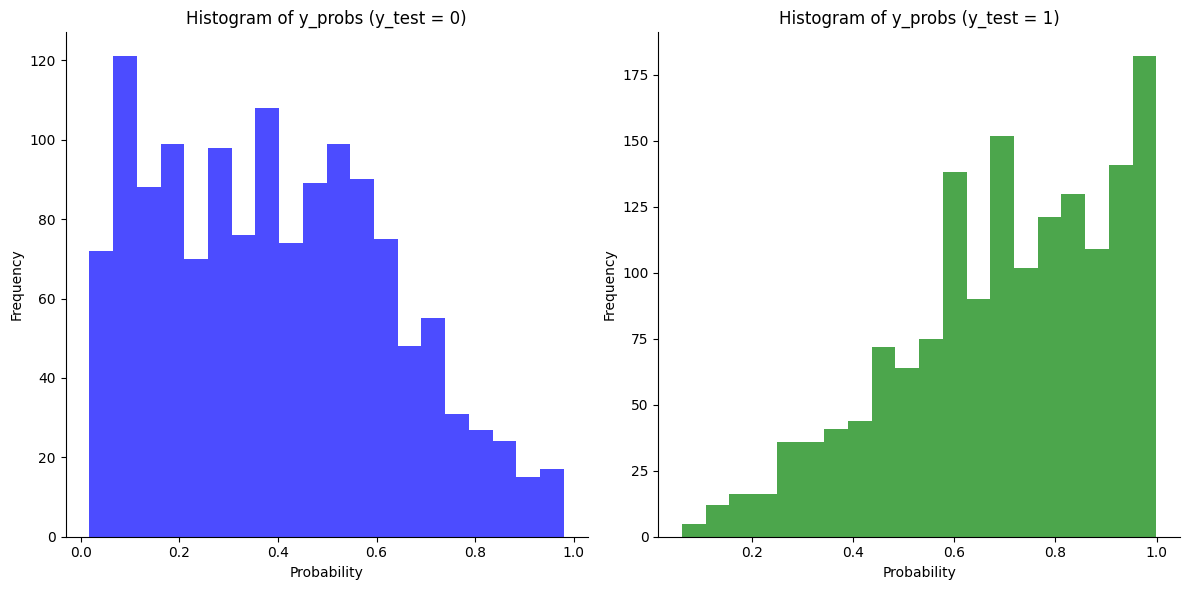

In [18]:
with torch.inference_mode(): 
    y_probs = torch.sigmoid(nn_model(X_test_tensor).squeeze())
    y_preds = torch.round(y_probs)


y_probs_np = y_probs.detach().numpy()
y_test_np = y_test_tensor.numpy()

y_probs_0 = y_probs_np[y_test_np == 0]
y_probs_1 = y_probs_np[y_test_np == 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(y_probs_0, bins=20, color='blue', alpha=0.7)
axes[0].set_title("Histogram of y_probs (y_test = 0)")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Frequency")

axes[1].hist(y_probs_1, bins=20, color='green', alpha=0.7)
axes[1].set_title("Histogram of y_probs (y_test = 1)")
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Frequency")

sns.despine()
plt.tight_layout()
plt.show()

Somewhat more systematically, we can inspect the ROC curve, the AUC-ROC score, and the confusion matrix. Seems like the surrogate performance is not too bad for a realistic challenge, so we will move to querying the surrogate next. Ideally, we should develop a range of somewhat different surrogates and query them all to ensure robustness. In what follows, for the sake of brevity, we will focus on only one—this will still give us plenty of material to work with.

AUC-ROC Score: 0.82


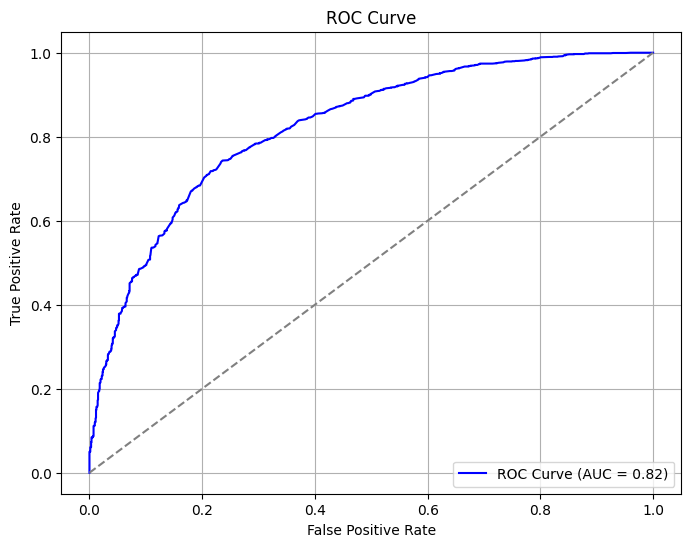

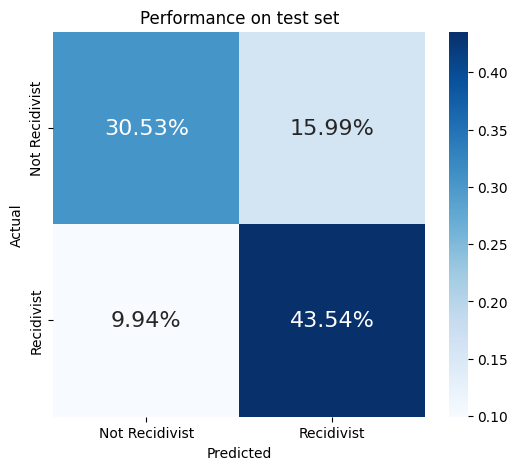

In [19]:
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC Score: {auc_score:.2f}")

# confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_preds)

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# plot confusion matrix
class_labels = ["Not Recidivist", "Recidivist"]
plt.figure(figsize=(6, 5))
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt=".2%", cmap="Blues", annot_kws={"size": 16},
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Performance on test set")
plt.show()

## Flat predictor

In what follows, we will focus on a particular person. This does not mean that `SearchForExplanation` cannot be used to obtain more global insights, we just chose to illustrate how it can be used to develop a local explanation. First, let's simply inspect that person's predictors, actual outome, and the probability and the outcome as predicted by the model.

In [20]:
person_index = 9
person_np = X_test.iloc[person_index]
person_out = y_test.iloc[person_index]
person_tensor = X_test_tensor[person_index,:]

with torch.inference_mode():
    persons_prob = torch.sigmoid(nn_model(person_tensor))
    persons_pred = torch.round(persons_prob)

print("person's features \n", person_np)
print("actual outcome", person_out)
print("person's tensor", person_tensor)
print("person's probability", persons_prob)
print("person's prediction", persons_pred)

person's features 
 age                      20.0
priors_count              1.0
race_African-American     1.0
Name: 5925, dtype: float64
actual outcome 1
person's tensor tensor([20.,  1.,  1.], dtype=torch.float64)
person's probability tensor([0.7091])
person's prediction tensor([1.])


We start with an approach that focuses on the surrogate model itself, assuming no dependence between inputs and no causal structure above it. In further steps, we will be adding these features, showing how this leads to a more nuanced picture. For now, we wrap the NN surrogate within a ChiRho model that simply registers the inputs, passes them on to the surrogate making sure the tensor shapes behave properly, and returns the surrogate outcome. We also render resulting straightforward model structure.

/home/rafal/miniconda3/envs/chirho3/lib/python3.13/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


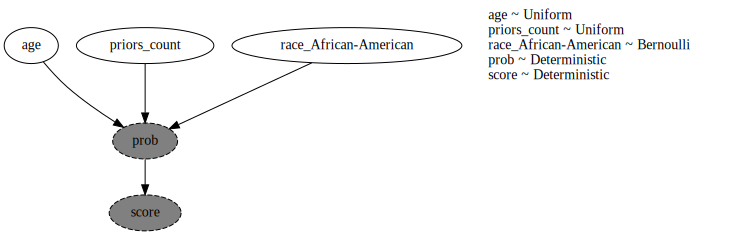

In [21]:
def pass_tensors_to_model(model, tensors_dict):
    tensors = tensors_dict.values()
    tensors = [t.unsqueeze(0) if t.dim() == 0 else t for t in tensors]
    shapes = [tensor.shape for tensor in tensors]
    common_shape = torch.broadcast_shapes(*shapes)
    broadcasted_tensors = [tensor.expand(common_shape) for tensor in tensors]
    input_tensor = torch.cat(broadcasted_tensors, dim=-1)
    
    with torch.inference_mode():
        prob = pyro.deterministic("prob", torch.sigmoid(model(input_tensor)))
        score = pyro.deterministic(
            "score",
            torch.round(prob)
        )

    return score


def flat_predictor(base_model = nn_model):
    
    # sampling to register the inputs
    # will be conditioned on anyway
    variable_distributions = {
        "age": dist.Uniform(18, 90),
        "priors_count": dist.Uniform(0, 40),
        "race_African-American": dist.Bernoulli(0.5)
    }

    input = {
        name: pyro.sample(name, distribution).float()
        if isinstance(distribution, dist.Bernoulli) else pyro.sample(name, distribution)
        for name, distribution in variable_distributions.items()
    }


    score = pass_tensors_to_model(base_model, input)

pyro.render_model(flat_predictor, model_args=(nn_model,), render_distributions=True, render_deterministic=True)

In [22]:
# By conditioning on the subject's data, we can replicate the factual prediction

data = {column: torch.tensor(person_np[column], dtype=torch.float32) for column in person_np.index}

with condition(data = data):
    with pyro.poutine.trace() as tr:
        flat_predictor(nn_model)

for key in tr.trace.nodes.keys():
    print(key, tr.trace.nodes[key]['value'], tr.trace.nodes[key]['value'].dtype)

age tensor(20.) torch.float32
priors_count tensor(1.) torch.float32
race_African-American tensor(1.) torch.float32
prob tensor([0.7091]) torch.float32
score tensor([1.]) torch.float32


Now, the first and somewhat naive move we can make to inspect the impact of the predictors on the surrogate's prediction is to manually intervene with different variable values. We will be improving on this strategy in what follows, but we start with it to illustrate how adding nuance can change our picture of the problem.

In [ ]:
actions_race = {'race_African-American': torch.tensor(0.0),}
actions_age = {'age': torch.tensor(31.0),}
actions_priors = {'priors_count': torch.tensor(0),}


with do(actions = actions_race):
    with condition(data = data):
        with pyro.poutine.trace() as tr_race:
            flat_predictor(nn_model)


with do(actions = actions_age):
    with condition(data = data):
        with pyro.poutine.trace() as tr_age:
            flat_predictor(nn_model)

with do(actions = actions_priors):
    with condition(data = data):
        with pyro.poutine.trace() as tr_priors:
            flat_predictor(nn_model)

traces = [tr_race, tr_age, tr_priors]

probs = [tr.trace.nodes["prob"]["value"] for tr in traces]
preds = [tr.trace.nodes["score"]["value"] for tr in traces]

print("predicted score for race/age/priors interventions:", preds)
print("predicted probabilities for race/age/priors interventions:", probs)

predicted score for race/age/priors interventions: [tensor([1.]), tensor([0.]), tensor([1.])]
predicted probabilities for race/age/priors interventions: [tensor([0.5881]), tensor([0.4896]), tensor([0.6243])]


The first impression might be that neither changing the race, nor even resetting the number of priors to 0 could change the prediction. The only variable that seems capable of changing the outcome is age, and so one might be inclined to say that race did not play an important role in the prediction made for this subject (notice also, how probabilities are borderline near the threshold, and so the model isn't very confident).

In proceeding as above, we inutitively tried to answer a few counterfactual queries: "would the prediction differ, if the subject was of a different age?". "would it be different if the subject had a different number of priors?", etc. This assumes that responsiblity attributions of the form "is $X=x$ responsible for $Y=y$ can be asnwered postively just in case there is an alternative value $x'$ such that setting $X=x'$ leads to $Y\neq y$. Later on we will explain why we think that this is a bit too hasty. This also seems to require one to specify what the alternative setting should be. In the case of a binary variable, the answer is straightforward; in the case of priors, setting the value to 0 intuitively makes sense, but only because of material intuition that we're trying to find the most charitable case for the subject; in the case of age, 31 is by no means a priviledged value. What's a principled way to go about such specification of alternative values? One option is to search through them all and claim responsibility just in case even a single one of them would lead to a change. This, however, is suboptimal, as there is a strong difference between, say, a case where the prediction would be different only if their age was changed from 20 to 99, as contrasted with one in which changing the age even by one year would make a difference. For this reason, we will prefer *sampling* the alternative values from proposal distributions, and integrating the evaluation results: this gives us a slightly better understanding of the impact of a given variable. For the purpose of our notebok, we will be making some decisions, but the reader should feel free to make other decisions here, if they think they're justified. Here's a simple example using `age`.

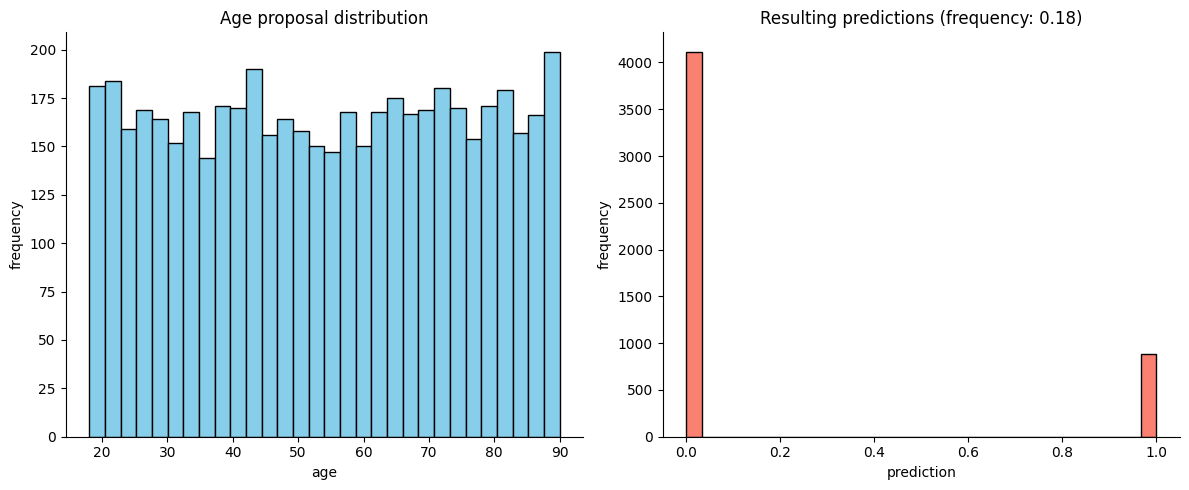

In [ ]:
# as an alternative we'll be passing a proposal sampling function
# here's a simple example
# and a simple histogram of the outcomes;
# note that the age is sampled from a uniform distribution
# and the resulting distribution of outcomes is push-forward

def sample_age(x):
    return dist.Uniform(18.0, 90.0).expand((num_samples,)).sample().unsqueeze(-1)

function_age = {
    'age': sample_age,
}

with do(actions = function_age):
    with condition(data = data):
        with pyro.poutine.trace() as tr_function_age:
            flat_predictor(nn_model)

ages = tr_function_age.trace.nodes['age']['value'].detach().cpu().numpy()
scores = tr_function_age.trace.nodes['score']['value'].detach().cpu().numpy()
frequency = (scores == 1).mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(ages, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Age proposal distribution')
axes[0].set_xlabel('age')
axes[0].set_ylabel('frequency')

axes[1].hist(scores, bins=30, color='salmon', edgecolor='black')
axes[1].set_title(f'Resulting predictions (frequency: {frequency:.2f})')
axes[1].set_xlabel('prediction')
axes[1].set_ylabel('frequency')

sns.despine()
plt.tight_layout()
plt.show()

## Sampling accross counterfactual worlds: walkthrough

The first stage at which `SearchForExplanation` will come handy is automating some of the interventions and search decisions (as discussed in the other tutorials, involving [categorical variables](https://basisresearch.github.io/chirho/explainable_categorical.html), [continuous variables](https://basisresearch.github.io/chirho/explainable_sir.html), and [actual causality](https://basisresearch.github.io/chirho/actual_causality.html)).We start with identifying the supports, and running the search with a very simple collection of parameters, for now indending pretty much to reproduce what we have done manually above.

In [36]:
with ExtractSupports() as extract_supports:
    flat_predictor(nn_model)
    flat_predictor_supports = extract_supports.supports
    flat_predictor_supports['score'] = constraints.boolean
    flat_predictor_supports['race_African-American'] = constraints.boolean


# data to be conditioned on needs to be reshaped here
reshaped_data = {
    key: value.expand((num_samples,)).unsqueeze(-1) for key, value in data.items()
}


pyro.set_rng_seed(13)
with MultiWorldCounterfactual() as mwc:
    with SearchForExplanation(
        supports=flat_predictor_supports,
        antecedents={'age': torch.tensor(20.0)},
        consequents={"score": torch.tensor(1.0)},
        witnesses= {}, # empty for now, will be discussed later
        alternatives=function_age, # for now, only age
        consequent_scale=1e-5,):

        with pyro.poutine.trace() as tr:
            with pyro.plate("samples", size=num_samples, dim=-2):
                with condition(data=reshaped_data):
                    flat_predictor(nn_model)

/home/rafal/s78projects/chirho/chirho/observational/handlers/condition.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pyro.factor(f"{self.prefix}{msg['name']}", torch.tensor(factor(msg["value"])))


What effectively happens under the hood is that three different possible worlds are played forward. The factual one, in which the variables have the values that the subject actually has, the "necessity" world, in which we investigate whether a given actual value was necessary for the outcome, by changing it to another alternative value, and the "sufficiency" world, in which we investigate the probability with which interventing on the variable with the factual value would ensure the outcome. Ultimately, what we will care about is the joint probability of the outcome being different in the "necessity" world and it being the same in the "sufficiency" world. For now, let's focus on the necessity world. Our search takes the antecedent preemption probability (set to .5 without any antecedent bias, see the other tutorials for a discussion), and deploys the proposed alternative intervention whenever it is not preempted. We can take a look at the resulting values.

In [37]:
frame = extract_samples(tr, mwc)
display(frame.drop_duplicates().head(4))

,age_base,age_nec,age_suf,age_i,prio_base,prio_nec,prio_suf,race_base,race_nec,race_suf,prob_base,prob_nec,prob_suf,scor_base,scor_nec,scor_suf,scor_c_nec,scor_c_suf
0,20.0,20.000000,20.0,1,1.0,1.0,1.0,1.0,1.0,1.0,0.709098,0.709098,0.709098,1.0,1.0,1.0,-11.511568,-0.00001
1,20.0,52.515404,20.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.709098,0.134867,0.709098,1.0,0.0,1.0,-0.000010,-0.00001
3,20.0,19.087715,20.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.709098,0.724793,0.709098,1.0,1.0,1.0,-11.511568,-0.00001
4,20.0,19.101818,20.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.709098,0.724555,0.709098,1.0,1.0,1.0,-11.511568,-0.00001


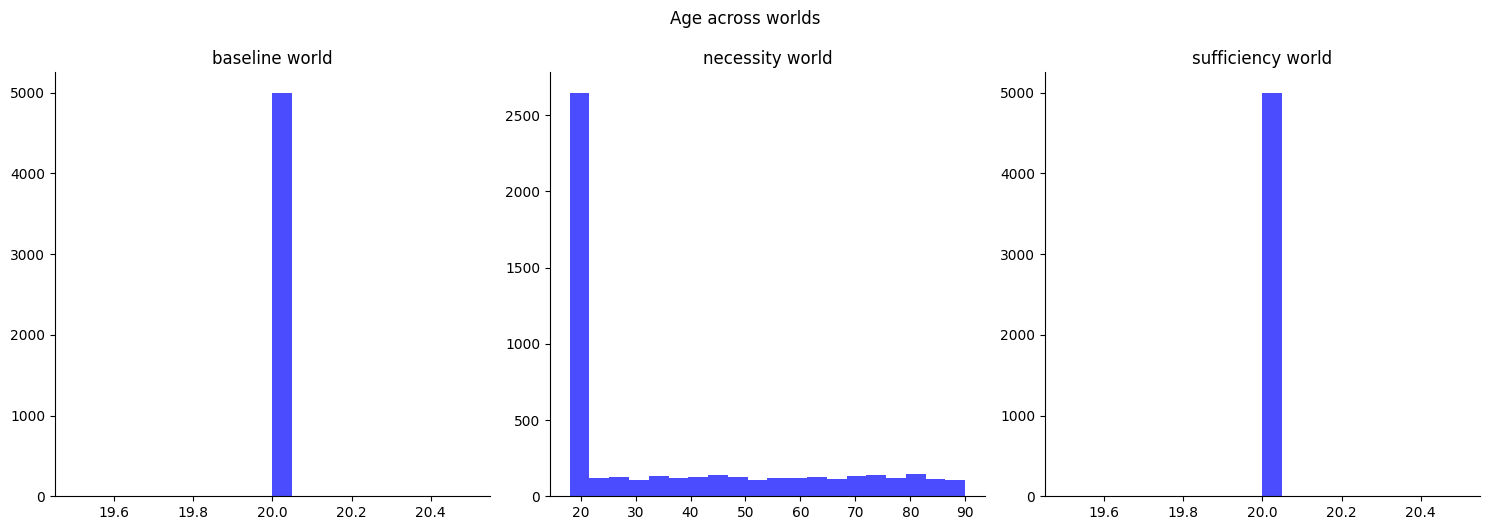

In [38]:
plot_world_histograms(frame, "age")

One estimand of interest might be the probability of the outcome being different in the necessity world if the alternative intervention is applied. We can inspect the distribuion of predicted probabilites and decisions as a function of proposed age alternative as follows.

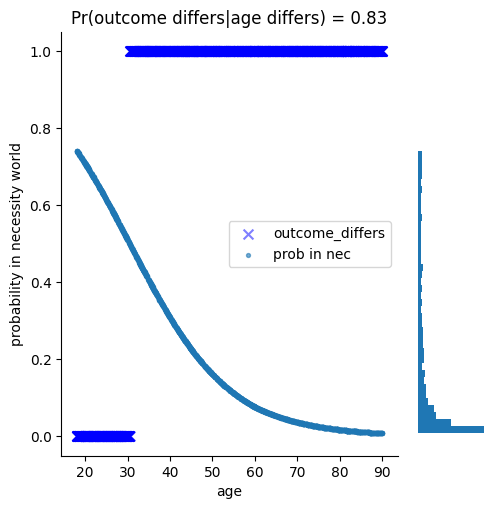

In [39]:
plot_conditioned_on_intervention(frame, "age")